# Yelp Reviews - Restaurant Review Topic Analysis  
* Ankur Vishwakarma  
* Metis SF Winter 2018

## Notebook 2 - Text processing  
Previous notebook - [1_extracting_reviews](1_extracting_reviews)  

---

## Table of Contents  
1. [Stopwords](#s1)
2. [TFIDF](#s2)
3. [LSA](#s3)
4. [NMF](#s4)
5. [Review Similarity in NMF space](#s5)
6. [Count Vectorizer](#s6)
7. [LDA](#s7)
8. [Continuing with NMF Topics](#s8)
9. [Topic Modeling All Reviews](#s9)
10. [Adding Topic Weights to Pandas DataFrame](#s10)
11. [Adding in Business Information](#s11)

In [1]:
# import initial modules
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [695]:
# read in reviews from previous notebook
df = pd.read_csv('reviews_OH_restaurants.csv')
df = df.drop(labels='Unnamed: 0', axis=1)

Let's check if that data loaded in fine. 

In [696]:
df.head(3)

,_id,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,5a95ffceae7ebe8216ae048c,meXjqyhTNLFmknY39y2sMg,1,2014-09-11,1,OPZsR2jCG72uoDNjU71DQQ,5,Solid beers -- Christmas Ale defines my holida...,1,qYbWTWH5leltA0bzWAOnmA
1,5a95ffceae7ebe8216ae085d,LNsZJP6jZ11e0tDljOLPiQ,0,2015-06-15,0,exyLwRWzDBraqy3UYvnexQ,4,Great vibe + loud crowd for a game + $5 craft ...,0,XuCbLgo9j1q5dDh9251vkg
2,5a95ffceae7ebe8216ae0b29,7ot8LYmnLhiN726E9dtAgA,0,2012-01-30,0,MnpmRSJR6A1Gup659Y5Slg,4,The food is always good and appropriately pric...,1,IaGVz-MDYSL0TtRoCe84aA


It did! Let's add length data for each review.

In [697]:
df['review_length'] = df.text.map(len)

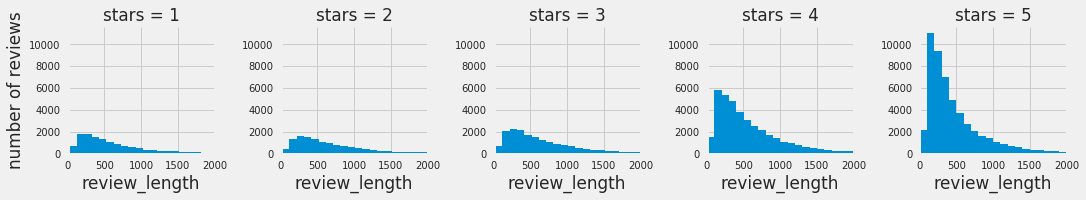

In [698]:
# check how the review lengths are distributed
ax = sns.FacetGrid(data=df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

The distribution of the length of reviews is simliar for each star rating. That's good - that means our tokenization should have about equal text data for both positive and negative reviews.

However, we do have a lot more reviews that are positive than negative. We'll see if that's a problem later on. For now, we'll split 1 and 2 star reviews into negative reviews and 4 and 5 star reviews into positive reviews.

In [699]:
pos_reviews = df.text[df.stars>3].values
neg_reviews = df.text[df.stars<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  90,311
Negative Reviews:  26,733


### Stopwords <a name='s1'></a>

In [700]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'Cleveland', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

### TFIDF <a name='s2'></a>

In [701]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

CPU times: user 2.3 s, sys: 8 ms, total: 2.3 s
Wall time: 2.3 s


In [702]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [703]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:['great', 'place', 'service', 'best', 'delicious', 'time', 'love', 'order']
Top 8 words in NEGATIVE reviews:['order', 'place', 'service', 'time', 'minutes', 'restaurant', 'table', 'chicken']


A few takeaways here:  
1. Looks like the top words for both positive and negative Yelp reviews mainly revolve around service. 
2. There are subtle differences though, such as positive reviews having more adjectives and emotional expressions, such as "delicious" or "love", and negative reviews having more nouns, such as "minutes" and "table". 
3. This shows that topic analysis is needed here to move past which words occur the most and analyze which words tend to group together in similar spaces. 

In [704]:
# delete dataframes to save memory
del neg_df
del pos_df

### LSA <a name='s3'></a>

In [705]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [706]:
# create LSA model
num_topics = 20
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

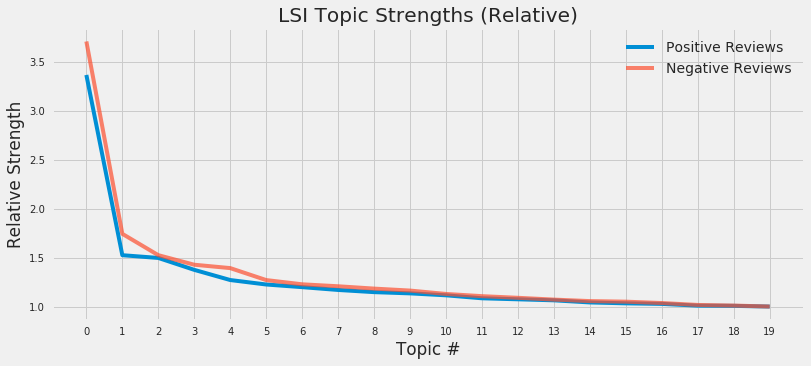

In [707]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

The **relative elbow plot** above shows that our first topic is approximately 3.5 times stronger of a differentiator than the rest of the topics. The concept of diminishing returns is in full display here. Let's move forward with picking the first 6 or 7 topics for further analysis. 

In [708]:
topics_to_print = 5

In [709]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.287*"great" + 0.231*"place" + 0.181*"service" + 0.132*"time" + '
  '0.132*"best" + 0.130*"order" + 0.130*"delicious" + 0.125*"love" + '
  '0.121*"nice" + 0.117*"pizza"'),
 (1,
  '-0.732*"pizza" + 0.404*"great" + 0.184*"service" + -0.147*"crust" + '
  '-0.119*"order" + 0.117*"atmosphere" + -0.115*"sauce" + 0.097*"place" + '
  '-0.094*"cheese" + 0.086*"friendly"'),
 (2,
  '0.555*"pizza" + 0.489*"great" + -0.170*"order" + 0.164*"service" + '
  '-0.150*"chicken" + 0.112*"atmosphere" + 0.110*"staff" + 0.105*"place" + '
  '-0.091*"burger" + 0.088*"crust"'),
 (3,
  '-0.676*"burger" + -0.288*"beer" + -0.244*"fries" + 0.178*"sushi" + '
  '-0.158*"bar" + -0.144*"selection" + 0.116*"thai" + 0.109*"service" + '
  '0.103*"friendly" + -0.100*"cheese"'),
 (4,
  '-0.395*"place" + -0.369*"love" + -0.314*"best" + 0.275*"great" + '
  '-0.247*"burger" + -0.195*"sushi" + -0.181*"cleveland" + 0.166*"service" + '
  '0.133*"excellen

In [710]:
# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.226*"order" + 0.190*"place" + 0.190*"service" + 0.159*"time" + '
  '0.149*"minutes" + 0.123*"table" + 0.118*"restaurant" + 0.113*"server" + '
  '0.104*"bar" + 0.099*"chicken"'),
 (1,
  '0.311*"minutes" + -0.243*"chicken" + -0.205*"pizza" + 0.178*"table" + '
  '-0.166*"sauce" + 0.162*"waited" + 0.156*"wait" + 0.147*"service" + '
  '-0.123*"cheese" + 0.114*"seated"'),
 (2,
  '0.906*"pizza" + -0.151*"burger" + -0.110*"chicken" + 0.110*"crust" + '
  '0.080*"minutes" + -0.066*"sushi" + -0.066*"rice" + -0.064*"fries" + '
  '0.054*"delivery" + 0.054*"pepperoni"'),
 (3,
  '-0.365*"burger" + -0.354*"order" + 0.314*"place" + 0.257*"service" + '
  '-0.211*"minutes" + -0.178*"chicken" + 0.157*"sushi" + -0.153*"fries" + '
  '-0.122*"cheese" + -0.118*"took"'),
 (4,
  '-0.710*"burger" + 0.258*"chicken" + -0.210*"fries" + -0.153*"beer" + '
  '0.152*"order" + 0.139*"rice" + -0.135*"place" + 0.130*"sushi" + '
  '0.114*"thai" +

Here's the difficulty in interpretation with LSA. Several of our topics have very strong negative weights for words. While that makes sense mathematically, it's harder to make sense of for our purpose. How do we provide insights to a business owner for what people liked and disliked about their restaurant by telling them the most excluded words?  

Therefore, we'll try NMF - it'll return only positive word weights.

### NMF <a name='s4'></a>

In [711]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 31.1 s, sys: 480 ms, total: 31.6 s
Wall time: 4.01 s


In [712]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.108*order, 0.935*chicken, 0.750*delicious, 0.709*time, 0.610*restaurant, 0.607*sauce
Topic 1:   3.142*pizza, 0.587*crust, 0.256*best, 0.225*pepperoni, 0.219*toppingss, 0.218*sauce
Topic 2:   3.239*great, 1.511*service, 0.789*atmosphere, 0.525*beer, 0.471*selection, 0.465*excellent
Topic 3:   2.629*burger, 0.903*fries, 0.699*beer, 0.330*selection, 0.287*bar, 0.213*cheese
Topic 4:   2.131*place, 1.353*love, 0.863*friendly, 0.834*staff, 0.603*breakfast, 0.467*amazing
Topic 5:   1.854*best, 1.788*sushi, 1.072*cleveland, 0.501*thai, 0.491*pho, 0.430*roll

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.898*place, 0.628*restaurant, 0.624*bar, 0.566*great, 0.544*better, 0.541*beer
Topic 1:   1.296*chicken, 0.792*order, 0.712*sauce, 0.642*salad, 0.524*rice, 0.454*cheese
Topic 2:   2.981*pizza, 0.372*crust, 0.282*cheese, 0.217*sauce, 0.217*order, 0.179*pepper

As expected, these topics are far more interpretable.  
* First two topics for positive reviews seem to be (1) speed/availability and (2) pizza.
* First two topics for negative reviews seem to be (1) slow service and (2) food (seems like thai food in this subset of data).

### Review Similarity in NMF space <a name='s5'></a>

In [492]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

6877
Good food, fast service. It makes me a little sad that '80's music is considered retro but that's life. 
Clean, great decor & branding. Fun place to eat.


In [493]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [494]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Great friendly staff, willing to talk to you even tho language barrier, my bf and I had a date night here recently and will return! Keep it up guys!
--------------------------------------------------
>> Similarity 1.000
My daughter and I were looking for a new breakfast adventure and we stumbled on Village Gardens.  Great, fast service for breakfast, good traditional fare with nice portions.

We went with the "cars in the parking lot" meter to help guide us and it didnt fail - great place.  Not much more to share other than we'll be back.
--------------------------------------------------
>> Similarity 1.000
Reasonable price. Good enough sushi. Interesting location. I was told this is the best sushi in the vicinity.  K.

The service was great and everyone was really nice. Not crowded at all
--------------------------------------------------


NMF seems to be working well and making good topics for us. But just to give it a shot, let's use CountVectorizer (instead of TFIDF) and try topic modeling through LDA. While slower, its use of a dirichlet prior can often give good results.

### Count Vectorizer <a name='s6'></a>

In [533]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [534]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

### LDA <a name='s7'></a>

In [535]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 3min 15s, sys: 15.9 s, total: 3min 31s
Wall time: 3min 14s


In [536]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.013*"great" + 0.012*"service" + 0.009*"delicious" + 0.009*"order" + '
  '0.008*"menu" + 0.008*"place" + 0.008*"restaurant"'),
 (1,
  '0.019*"pizza" + 0.013*"time" + 0.011*"order" + 0.011*"burger" + '
  '0.011*"great" + 0.009*"place" + 0.008*"fries"'),
 (2,
  '0.016*"place" + 0.014*"great" + 0.008*"chicken" + 0.007*"sauce" + '
  '0.007*"service" + 0.007*"order" + 0.007*"try"'),
 (3,
  '0.023*"place" + 0.022*"great" + 0.012*"bar" + 0.010*"best" + '
  '0.010*"service" + 0.010*"cleveland" + 0.007*"beer"'),
 (4,
  '0.023*"great" + 0.017*"place" + 0.011*"menu" + 0.010*"friendly" + '
  '0.008*"order" + 0.008*"price" + 0.008*"love"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.021*"order" + 0.015*"minutes" + 0.012*"table" + 0.012*"service" + '
  '0.010*"time" + 0.009*"waitress" + 0.008*"server"'),
 (1,
  '0.015*"order" + 0.013*"place" + 0.013*"chicken" + 0.0

In this case, it seems that our LDA topics are more blended together into each other than the ones generated by NMF. Let's move forward with NMF.

### Continuing with NMF Topics <a name='s8'></a>

In [713]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.108*order, 0.935*chicken, 0.750*delicious, 0.709*time, 0.610*restaurant, 0.607*sauce
Topic 1:   3.142*pizza, 0.587*crust, 0.256*best, 0.225*pepperoni, 0.219*toppingss, 0.218*sauce
Topic 2:   3.239*great, 1.511*service, 0.789*atmosphere, 0.525*beer, 0.471*selection, 0.465*excellent
Topic 3:   2.629*burger, 0.903*fries, 0.699*beer, 0.330*selection, 0.287*bar, 0.213*cheese
Topic 4:   2.131*place, 1.353*love, 0.863*friendly, 0.834*staff, 0.603*breakfast, 0.467*amazing
Topic 5:   1.854*best, 1.788*sushi, 1.072*cleveland, 0.501*thai, 0.491*pho, 0.430*roll


In [715]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #4269
-------------------------
-Delicious, fresh, authentic Thai food (we order the summer rolls w/ tofu as an appetizer and for mains I had red curry and my boyfriend had the mixed grill)
-Quick/friendly service
-Easy to use Groupon
-Full bar
-Would suggest they play music to improve ambiance (it was pretty quiet)

Overall a really good experience
-------------------------
Topic 0: 0.0279
Topic 5: 0.0171
Topic 2: 0.0121
Topic 4: 0.0067
Topic 1: 0.0000
Topic 3: 0.0000


In [688]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.672*minutes, 1.250*order, 1.150*table, 0.800*waited, 0.797*wait, 0.771*server
Topic 1:   1.206*chicken, 0.783*order, 0.700*sauce, 0.637*salad, 0.501*tasted, 0.499*rice
Topic 2:   3.039*pizza, 0.396*crust, 0.251*cheese, 0.239*order, 0.232*pepperoni, 0.223*sauce
Topic 3:   3.160*burger, 0.974*fries, 0.322*cheese, 0.317*medium, 0.259*order, 0.254*bun
Topic 4:   1.627*place, 0.697*bar, 0.529*staff, 0.520*people, 0.497*beer, 0.490*restaurant
Topic 5:   2.283*service, 0.805*terrible, 0.792*slow, 0.772*horrible, 0.446*poor, 0.370*bad


In [693]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #10819
-------------------------
Someone dropped the ball last night or the restaurant doesn't care about take out orders.  Ordered takeout last night.  Just simple penne pasta with sausage and meatballs and Caesar salad.  The pasta was not cooked well, the food was cold when we received it.  Salad was not a Caesar salad nor was the dressing and the bread hadn't been warmed up at all like it usually is.  Sausage very blah.  Will never order carry out from here again.  Cost me $35 when I could have went to the local pizza shop and had the same thing that would have been much better for $10.00.  So disappointed.
-------------------------
Topic 1: 0.0476
Topic 2: 0.0452
Topic 0: 0.0048
Topic 3: 0.0000
Topic 4: 0.0000
Topic 5: 0.0000


### Topic Modeling All Reviews <a name='s9'></a>  
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [720]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  90,311
Negative Reviews:  26,733


In [721]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

CPU times: user 6.24 s, sys: 28 ms, total: 6.27 s
Wall time: 6.26 s


In [722]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 1min 52s, sys: 1.46 s, total: 1min 53s
Wall time: 14.3 s


In [959]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   2.295*beer, 2.214*bar, 1.432*selection, 1.147*nice, 1.144*happy, 1.048*hour
Topic 1:   4.475*pizza, 0.769*crust, 0.376*best, 0.320*pepperoni, 0.292*sauce, 0.271*cheese
Topic 2:   4.332*great, 2.059*service, 0.919*atmosphere, 0.735*excellent, 0.484*price, 0.474*friendly
Topic 3:   3.942*burger, 1.435*fries, 0.314*cheese, 0.305*onion, 0.294*rings, 0.283*best
Topic 4:   2.569*place, 1.921*love, 1.460*best, 1.012*staff, 0.988*friendly, 0.968*sushi
Topic 5:   1.544*order, 1.342*chicken, 1.062*delicious, 0.924*time, 0.831*sauce, 0.814*salad

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   2.040*place, 0.780*bar, 0.619*great, 0.613*restaurant, 0.602*beer, 0.596*people
Topic 1:   1.315*chicken, 0.840*order, 0.748*sauce, 0.677*salad, 0.527*rice, 0.511*cheese
Topic 2:   3.210*pizza, 0.397*crust, 0.261*cheese, 0.238*order, 0.208*sauce, 0.191*pepperoni
Topic 3:   1.685*minutes, 1.217*order

In [809]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'beer/happy_hour', 1:'food/pizza', 2:'service/atmosphere', 
              3:'food/burger/fries', 4:'friendly_staff', 5:'food/chicken/salad'}

neg_topics = {0:'beer/people', 1:'food/chicken/salad', 2:'food/pizza', 
              3:'wait/table', 4:'food/burger/fries', 5:'bad_service'}

### Adding Topic Weights to Pandas DataFrame <a name='s10'></a>

In [1036]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = df[['business_id', 'stars', 'text', 'review_length']][df.stars>3].reset_index()
df_neg = df[['business_id', 'stars', 'text', 'review_length']][df.stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

Our topic weights are not immediately relevant as absolute numbers. Let's take a look. 

In [1037]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [ 0.02463009  0.00101522  0.02202031  0.00129422  0.00141343  0.00251745]
Sum of weights:  0.052890716701


To a business owner, it does not make sense that that a review they received is 0.025 topic 0 and all their topics sum up to 0.053. Therefore, we can normalize the weights so they all add up to 1. 

In [1038]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[ 0.46567886  0.01919461  0.41633593  0.02446968  0.02672364  0.04759728]]
Sum of normalized weights:  1.0


In [1040]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [1041]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,Bd13s20et9wY2sL72lgWow,1,"This was obviously just not my atmosphere, I w...",739,0.714657,0.180766,0.072080,0.000000,0.032498,0.000000
1,ITde2CeOZ6fUG9h3xb-Nag,2,This rating is based on food quality and staff...,531,0.253483,0.475451,0.000000,0.164919,0.000000,0.106148
2,NyLYY8q1-H3hfsTwuwLPCg,2,"Not impressed. As another Yelper said, she fou...",931,0.578168,0.387612,0.015409,0.000000,0.018811,0.000000
3,Im0hMcWaqWIzuBM8xILDsA,2,Unimpressed.\n\nI had been wanting to try this...,1479,0.170182,0.731674,0.024512,0.000000,0.073631,0.000000
4,EOghCHtoyxJQnVZnvKxmNQ,1,"This is a very late review, and is written onl...",1664,0.862346,0.111661,0.008353,0.017640,0.000000,0.000000


Great - we have topic weights for each review in this dataframe. Next, we can group by the business_id and get mean topic weights per restaurant.

In [1042]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [1043]:
df_pos_bsns.head(5)

,business_id,stars,text,review_length,0,1,2,3,4,5
0,--I7YYLada0tSLkORTHb5Q,4.487805,41,337.707317,0.247308,0.012125,0.252212,0.132580,0.150639,0.205137
1,-49WY_TEa9ZEcRk_GnuLog,4.210526,19,314.368421,0.065293,0.007372,0.383144,0.007661,0.270563,0.265966
2,-8O8sVCnaIKHP-596zN9UA,4.606061,99,530.111111,0.163032,0.015570,0.294349,0.020918,0.170485,0.335647
3,-B_4pHQkzU12AMaYkkY4cw,4.318182,44,525.431818,0.074764,0.026547,0.161418,0.075333,0.148506,0.513432
4,-Biboxy2pG3MovBOF_r4SQ,4.500000,8,471.125000,0.081066,0.014826,0.367548,0.078620,0.263452,0.194488


In [1044]:
df_neg_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,--I7YYLada0tSLkORTHb5Q,1.555556,18,715.166667,0.226518,0.205736,0.008840,0.212232,0.149451,0.197223
1,-49WY_TEa9ZEcRk_GnuLog,1.333333,6,616.166667,0.143072,0.340383,0.000000,0.295179,0.041138,0.180229
2,-8O8sVCnaIKHP-596zN9UA,1.609756,41,643.146341,0.261038,0.271779,0.010757,0.224146,0.023239,0.209041
3,-B_4pHQkzU12AMaYkkY4cw,1.625000,16,816.125000,0.153000,0.591237,0.013282,0.141182,0.045399,0.055899
4,-Biboxy2pG3MovBOF_r4SQ,1.421053,19,548.000000,0.370449,0.116606,0.016689,0.347139,0.023664,0.125453


### Adding in Business Information <a name='s11'></a>

In [1045]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe
oh_df = pd.read_csv('OH_restaurants.csv')
oh_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [1046]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(oh_df[['id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(oh_df[['id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

In [1047]:
# peek into business/topic distributions
df_pos_tot.head()

,business_id,name,city,stars_y,0,1,2,3,4,5
0,--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,Streetsboro,3.5,0.247308,0.012125,0.252212,0.132580,0.150639,0.205137
1,-49WY_TEa9ZEcRk_GnuLog,Cracker Barrel Old Country Store,Sheffield Village,3.5,0.065293,0.007372,0.383144,0.007661,0.270563,0.265966
2,-8O8sVCnaIKHP-596zN9UA,Blue Canyon Kitchen & Tavern,Twinsburg,3.5,0.163032,0.015570,0.294349,0.020918,0.170485,0.335647
3,-B_4pHQkzU12AMaYkkY4cw,Old Carolina Barbecue Company,Strongsville,3.5,0.074764,0.026547,0.161418,0.075333,0.148506,0.513432
4,-Biboxy2pG3MovBOF_r4SQ,Perkins Restaurant & Bakery,Middleburg Heights,2.5,0.081066,0.014826,0.367548,0.078620,0.263452,0.194488


We can check topic distributions for a business and see how they make sense after all the reviews have been normalized and then averaged up to the business-level. Let's check `business_id 'uOPzOiwkS_6w4txA7fYfeA'`, which happens to be a popular chili spot in Ohio.

In [1051]:
scores = df_pos_bsns[df_pos_bsns.business_id == 'uOPzOiwkS_6w4txA7fYfeA'].iloc[:,-6:].values
print(oh_df[oh_df.id == 'uOPzOiwkS_6w4txA7fYfeA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Skyline Chili - Positive Reviews
------------------------------------
Topic 0: beer/happy_hour    > 0.0767
Topic 1: food/pizza         > 0.0327
Topic 2: service/atmosphere > 0.0818
Topic 3: food/burger/fries  > 0.0891
Topic 4: friendly_staff     > 0.3543
Topic 5: food/chicken/salad > 0.3655


We now have 4 dataframes:  
1. **`df_pos_tot`: ** topic distribution of positive reviews with name, city, and stars for all restaurants
2. **`df_neg_tot`: ** topic distribution of negative reviews with name, city, and stars for all restaurants
3. **`df_pos`: ** topic distribution of all positive reviews with associated business_id
4. **`df_neg`: ** topic distribution of all negative reviews with associated business_id  

We can write them to CSV files and then use that information for visualizations in Tableau.

In [1068]:
%%time
# write to CSV
df_pos_tot.to_csv('CSVs/pos_bsns.csv')
df_neg_tot.to_csv('CSVs/neg_bsns.csv')
df_pos.to_csv('CSVs/pos_reviews.csv')
df_neg.to_csv('CSVs/neg_reviews.csv')

CPU times: user 1.82 s, sys: 84 ms, total: 1.9 s
Wall time: 1.9 s
